In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_validate
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing

import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode
import plotly.graph_objs as go
import plotly.io as pio

init_notebook_mode(connected=True)

red_path = "./res/winequality-red.csv"
white_path = "./res/winequality-white.csv"
result_folder = "./results/"

test_set_ratio = 0.1

### Preprocessing

In [2]:
df_red = pd.read_csv(red_path,";")
df_red['type'] = 0
df_white = pd.read_csv(white_path, ";")
df_white['type'] = 1


#df_train = pd.concat([df_red])
#df_train = pd.concat([df_white])
df_train = pd.concat([df_red,df_white])


## add ID column
df_train['quality'] = [4 if (x==3 or x==4) else x for x in df_train['quality']]
df_train['quality'] = [8 if (x==8 or x==9) else x for x in df_train['quality']]
df_train['quality'] = df_train['quality']-3

#df_train['quality'] = [0 if (x<=6) else x for x in df_train['quality']]
#df_train['quality'] = [1 if (x>6) else x for x in df_train['quality']]

df_train = df_train.reset_index(drop=True)
bip = df_train.groupby(['quality']).agg(['count'])

bip

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
,count,count,count,count,count,count,count,count,count,count,count,count
quality,,,,,,,,,,,,
1,246,246,246,246,246,246,246,246,246,246,246,246
2,2138,2138,2138,2138,2138,2138,2138,2138,2138,2138,2138,2138
3,2836,2836,2836,2836,2836,2836,2836,2836,2836,2836,2836,2836
4,1079,1079,1079,1079,1079,1079,1079,1079,1079,1079,1079,1079
5,198,198,198,198,198,198,198,198,198,198,198,198


In [ ]:
#Normalize
#cols = list(df_train)
#a = df_train.values
#b = preprocessing.scale(a[:,0:11], axis=0, with_mean=True, with_std=True, copy=True)

#df_train = np.concatenate((b,df_train.values[:,[11,12]]), axis=1)
#df_train = pd.DataFrame(df_train, columns = cols)

In [3]:
df_train.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,2,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,2,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,2,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,3,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,2,0
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,2,0
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,2,0
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,4,0
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,4,0
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,2,0


### Initialize Training data

In [ ]:
df_vars = df_train.loc[:, df_train.columns != 'quality']
df_class = df_train['quality']

### Hyper-parameter tuning

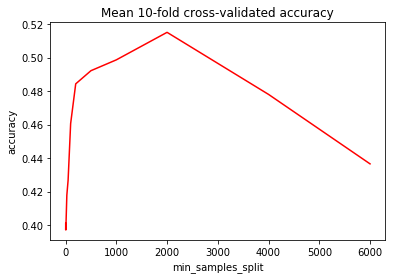

In [14]:
min_samples_splits = [2,3,5,10,25,50,100,200,500,1000,2000,4000,6000]
results = []
for min_samples_split in min_samples_splits:
    clf = DecisionTreeClassifier(min_samples_split=min_samples_split)
    scores = cross_validate(clf, df_vars, df_class, cv=10)
    results.append(scores['test_score'].mean())
    
plt.plot(min_samples_splits, results, "r", label="Test Accuracy")
plt.ylabel("accuracy")
plt.xlabel("min_samples_split")
plt.title("Mean 10-fold cross-validated accuracy")
plt.show()

D:\Program_Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by the scale function.



0 --- 1e-05
[0.37019969 0.43932412 0.49615975 0.49155146 0.51920123 0.43932412
 0.58397535 0.4853621  0.49768161 0.47058824]
1 --- 0.0001
[0.37327189 0.49155146 0.47465438 0.50076805 0.53763441 0.4546851
 0.57935285 0.49614792 0.54404946 0.52321981]
2 --- 0.001
[0.40706605 0.51152074 0.47311828 0.48540707 0.52227343 0.51152074
 0.55007704 0.52696456 0.57341577 0.51702786]
3 --- 0.01
[0.41781874 0.50998464 0.46850998 0.47619048 0.51612903 0.50998464
 0.53929122 0.5238829  0.57805255 0.51393189]
4 --- 0.1


D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\b

[0.41781874 0.51459293 0.46082949 0.47311828 0.51612903 0.51152074
 0.54391371 0.52696456 0.58268934 0.51702786]
5 --- 1


D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\b

[0.41781874 0.51305684 0.45929339 0.47465438 0.51612903 0.51152074
 0.54545455 0.52696456 0.58268934 0.51702786]
6 --- 10


D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\b

[0.43625192 0.51459293 0.43010753 0.4562212  0.51152074 0.51766513
 0.54391371 0.52542373 0.58423493 0.52941176]
7 --- 100


D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\b

[0.4546851  0.40399386 0.52227343 0.46390169 0.32872504 0.44854071
 0.49614792 0.43605547 0.37712519 0.27708978]
8 --- 1000


D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\b

[0.42549923 0.34254992 0.4546851  0.28417819 0.41935484 0.4562212
 0.46070878 0.41448382 0.47449768 0.35913313]


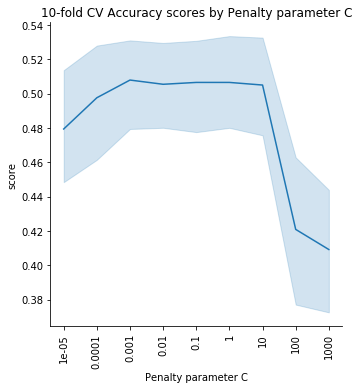

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

df_vars_all = df_train.loc[:, df_train.columns != 'quality']
df_vars = preprocessing.scale(df_vars)
df_class = df_train['quality']

C = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
results = []
for idx, c in enumerate(C):
    print(idx, "---", c)
    clf = LinearSVC(C=c)
    scores = cross_validate(clf, df_vars, df_class, cv=10)['test_score']
    print(scores)
    for score in scores:
        results.append({'score': score, 'x':idx, 'penalty':c})

df_trace = pd.DataFrame.from_dict(results)
g = sns.relplot(x="x", y="score", kind="line", data=df_trace)
plt.xticks(range(len(C)), C, rotation='vertical')
plt.xlabel("Penalty parameter C")
plt.title("10-fold CV Accuracy scores by Penalty parameter C")
axes = plt.gca()
plt.savefig('scaled_wq_C_eval.pdf')
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

df_vars_all = df_train.loc[:, df_train.columns != 'quality']
df_class = df_train['quality']

params = [2,3,5,10,25,50,100,200,500,1000,2000,4000,6000]
results = []
for idx, c in enumerate(params):
    print(idx, "---", c)
    clf = DecisionTreeClassifier(min_samples_split=c, random_state=32143421)
    np.random.seed(32143421)
    scores = cross_validate(clf, df_vars, df_class, cv=5, return_train_score=True)
    print("Train", scores['train_score'])
    print("Test", scores['test_score'])
    for score in scores['test_score']:
        results.append({'score': score, 'x':idx, 'penalty':c, 'set':'test'})
    for score in scores['train_score']:
        results.append({'score': score, 'x':idx, 'penalty':c, 'set':'train'})

df_trace = pd.DataFrame.from_dict(results)
g = sns.relplot(x="x", y="score", kind="line", hue="set", style="set", data=df_trace)
plt.xticks(range(len(params)), params, rotation='vertical')
plt.xlabel("Min samples for split")
plt.title("10-fold CV Accuracy scores by min_samples_split")
axes = plt.gca()
plt.savefig('wq_mss_eval.pdf')
plt.show()

### Scale or not Scale

In [ ]:
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors.nearest_centroid import NearestCentroid

df_vars_all = df_train.loc[:, df_train.columns != 'quality']
df_vars_scaled = preprocessing.scale(df_vars)
df_class = df_train['quality']

names = ["Nearest Centroid", "Linear SVM",
         "Decision Tree", "Naive Bayes"]

classifiers = [
    NearestCentroid(),
    LinearSVC(),
    DecisionTreeClassifier(),
    GaussianNB()]

for name, clf in zip(names, classifiers):
    np.random.seed(32143421)
    scores = cross_validate(clf, df_vars, df_class, cv=10)['test_score']
    print(name, "Unscaled", scores.mean())
    np.random.seed(32143421)
    scores = cross_validate(clf, df_vars_scaled, df_class, cv=10)['test_score']
    print(name, "Scaled", scores.mean())

### Easy comparison

In [10]:
import traceback
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

df_vars_all = df_train.loc[:, df_train.columns != 'quality']
df_vars = df_vars_all
df_class = df_train['quality']

scaler = MinMaxScaler()
scaler.fit(df_vars)
df_vars_scaled=scaler.transform(df_vars)

#df_vars = KNN(k=3).fit_transform(df_vars)

names = ["Nearest Centroid", "Linear SVM",
         "Decision Tree", "Naive Bayes"]

classifiers = [
    NearestCentroid(),
    LinearSVC(),
    DecisionTreeClassifier(),
    GaussianNB()]

cl_scores = {}
for name in names:
    cl_scores[name] = []

for feature_count in [1,2,5,6,7,8,9,10,11,0]:
    if feature_count != 0:
        df_vars = SelectKBest(chi2, k=feature_count).fit_transform(df_vars_all, df_class)
    else:
        df_vars = df_vars_all
    print("-"*60)
    print("Feature count=", feature_count if feature_count > 0 else "ALL")
    for name, clf in zip(names, classifiers):
        try:
            np.random.seed(32143421)
            scores = cross_validate(clf, df_vars, df_class, cv=10, scoring='accuracy', return_train_score=True)
            cl_scores[name].append(scores)
            print(name,"-- Training Set --", "Mean", scores['train_score'].mean(), "-- Min", scores['train_score'].min(), "-- Max", scores['train_score'].max())
            print(name,"-- Test Set --", "Mean", scores['test_score'].mean(), "-- Min", scores['test_score'].min(), "-- Max", scores['test_score'].max())
        except:
            print("Classification failed for", name)
            traceback.print_exc()

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.



------------------------------------------------------------
Feature count= 1
Nearest Centroid -- Training Set -- Mean 0.2142227425341269 -- Min 0.0673734610123119 -- Max 0.2858364693807732
Nearest Centroid -- Test Set -- Mean 0.20330512025378863 -- Min 0.05855161787365177 -- Max 0.31741140215716485


D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\b

Linear SVM -- Training Set -- Mean 0.3497155764017249 -- Min 0.17487179487179488 -- Max 0.43670886075949367
Linear SVM -- Test Set -- Mean 0.33354527737821427 -- Min 0.11128284389489954 -- Max 0.43808049535603716
Decision Tree -- Training Set -- Mean 0.4971703130157512 -- Min 0.49359083917279095 -- Max 0.5042764283270612
Decision Tree -- Test Set -- Mean 0.40841758436197917 -- Min 0.30721966205837176 -- Max 0.4622496147919877
Naive Bayes -- Training Set -- Mean 0.43895535464000696 -- Min 0.4357045143638851 -- Max 0.4503934314060896
Naive Bayes -- Test Set -- Mean 0.42822732475664943 -- Min 0.37019969278033793 -- Max 0.44838212634822805
------------------------------------------------------------
Feature count= 2


D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\b

Nearest Centroid -- Training Set -- Mean 0.18300007893415876 -- Min 0.09610123119015047 -- Max 0.28292849811837156
Nearest Centroid -- Test Set -- Mean 0.16765816683905513 -- Min 0.05222734254992319 -- Max 0.27956989247311825
Linear SVM -- Training Set -- Mean 0.30358796075521116 -- Min 0.1837292770466587 -- Max 0.4365378036264112
Linear SVM -- Test Set -- Mean 0.29464730027621444 -- Min 0.11093990755007704 -- Max 0.4362519201228879
Decision Tree -- Training Set -- Mean 0.8570628421091211 -- Min 0.8514021887824897 -- Max 0.8655490933971947
Decision Tree -- Test Set -- Mean 0.3461509683086391 -- Min 0.3065015479876161 -- Max 0.3898305084745763
Naive Bayes -- Training Set -- Mean 0.440186711605027 -- Min 0.43587551299589605 -- Max 0.44731440301060554
Naive Bayes -- Test Set -- Mean 0.41670661162469036 -- Min 0.34101382488479265 -- Max 0.4592933947772657
------------------------------------------------------------
Feature count= 5
Nearest Centroid -- Training Set -- Mean 0.184761213077040

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\b

Linear SVM -- Training Set -- Mean 0.398273150225697 -- Min 0.27213675213675215 -- Max 0.4673392612859097
Linear SVM -- Test Set -- Mean 0.38809916229581687 -- Min 0.18856259659969088 -- Max 0.5468509984639017
Decision Tree -- Training Set -- Mean 0.9998460865944233 -- Min 0.9998289428669176 -- Max 1.0
Decision Tree -- Test Set -- Mean 0.408702502636365 -- Min 0.36251920122887865 -- Max 0.4559505409582689
Naive Bayes -- Training Set -- Mean 0.503993276114069 -- Min 0.493157714676702 -- Max 0.50838179952104
Naive Bayes -- Test Set -- Mean 0.47886341022541734 -- Min 0.41321044546851 -- Max 0.539291217257319
------------------------------------------------------------
Feature count= 6
Nearest Centroid -- Training Set -- Mean 0.18474410736373223 -- Min 0.09712722298221614 -- Max 0.2834416695176189
Nearest Centroid -- Test Set -- Mean 0.16981393135776635 -- Min 0.05069124423963134 -- Max 0.282642089093702


D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\b

Linear SVM -- Training Set -- Mean 0.4207235149530197 -- Min 0.22630858706808074 -- Max 0.5205268559698939
Linear SVM -- Test Set -- Mean 0.42291383776098473 -- Min 0.1674347158218126 -- Max 0.5376344086021505
Decision Tree -- Training Set -- Mean 0.9998460865944233 -- Min 0.9998289428669176 -- Max 1.0
Decision Tree -- Test Set -- Mean 0.40913574896716165 -- Min 0.3579109062980031 -- Max 0.4591679506933744
Naive Bayes -- Training Set -- Mean 0.4593840409218878 -- Min 0.1515566199110503 -- Max 0.5047895997263085
Naive Bayes -- Test Set -- Mean 0.45559379804661626 -- Min 0.3686635944700461 -- Max 0.511520737327189
------------------------------------------------------------
Feature count= 7
Nearest Centroid -- Training Set -- Mean 0.18467571082848258 -- Min 0.09695622435020519 -- Max 0.2834416695176189
Nearest Centroid -- Test Set -- Mean 0.16950552276512726 -- Min 0.05069124423963134 -- Max 0.282642089093702


D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\b

Linear SVM -- Training Set -- Mean 0.36208368137950697 -- Min 0.09348829259955563 -- Max 0.47228874444064317
Linear SVM -- Test Set -- Mean 0.32165262505461184 -- Min 0.029411764705882353 -- Max 0.49001536098310294
Decision Tree -- Training Set -- Mean 1.0 -- Min 1.0 -- Max 1.0
Decision Tree -- Test Set -- Mean 0.416972227632065 -- Min 0.3579109062980031 -- Max 0.4530046224961479
Naive Bayes -- Training Set -- Mean 0.45462975216536305 -- Min 0.15035921997947316 -- Max 0.5023947998631543
Naive Bayes -- Test Set -- Mean 0.44467729209894963 -- Min 0.3533026113671275 -- Max 0.5053763440860215
------------------------------------------------------------
Feature count= 8
Nearest Centroid -- Training Set -- Mean 0.18467571082848258 -- Min 0.09695622435020519 -- Max 0.2834416695176189
Nearest Centroid -- Test Set -- Mean 0.16950552276512726 -- Min 0.05069124423963134 -- Max 0.282642089093702


D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\b

Linear SVM -- Training Set -- Mean 0.4029158194472841 -- Min 0.3421142661648991 -- Max 0.4586183310533516
Linear SVM -- Test Set -- Mean 0.38392939305400453 -- Min 0.22734254992319508 -- Max 0.47619047619047616
Decision Tree -- Training Set -- Mean 1.0 -- Min 1.0 -- Max 1.0
Decision Tree -- Test Set -- Mean 0.4105061807554506 -- Min 0.3686635944700461 -- Max 0.4470046082949309
Naive Bayes -- Training Set -- Mean 0.43094428391806894 -- Min 0.15737256243585357 -- Max 0.4791310297639412
Naive Bayes -- Test Set -- Mean 0.42103730310067417 -- Min 0.33539412673879443 -- Max 0.5038402457757296
------------------------------------------------------------
Feature count= 9
Nearest Centroid -- Training Set -- Mean 0.18467571082848258 -- Min 0.09695622435020519 -- Max 0.2834416695176189
Nearest Centroid -- Test Set -- Mean 0.16950552276512726 -- Min 0.05069124423963134 -- Max 0.282642089093702


D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\b

Linear SVM -- Training Set -- Mean 0.39029137749305914 -- Min 0.10434485118029421 -- Max 0.49880341880341883
Linear SVM -- Test Set -- Mean 0.3948916347713468 -- Min 0.18181818181818182 -- Max 0.5795981452859351
Decision Tree -- Training Set -- Mean 1.0 -- Min 1.0 -- Max 1.0
Decision Tree -- Test Set -- Mean 0.4064009371014051 -- Min 0.36098310291858676 -- Max 0.4622496147919877
Naive Bayes -- Training Set -- Mean 0.42463412676579076 -- Min 0.16985973315087238 -- Max 0.4693807731782415
Naive Bayes -- Test Set -- Mean 0.41672578648421715 -- Min 0.3384853168469861 -- Max 0.511520737327189
------------------------------------------------------------
Feature count= 10
Nearest Centroid -- Training Set -- Mean 0.18467571082848258 -- Min 0.09695622435020519 -- Max 0.2834416695176189
Nearest Centroid -- Test Set -- Mean 0.16950552276512726 -- Min 0.05069124423963134 -- Max 0.282642089093702


D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\b

Linear SVM -- Training Set -- Mean 0.3900475904666955 -- Min 0.2579541566883339 -- Max 0.49794801641586867
Linear SVM -- Test Set -- Mean 0.3894731396604267 -- Min 0.19040247678018576 -- Max 0.5069337442218799
Decision Tree -- Training Set -- Mean 1.0 -- Min 1.0 -- Max 1.0
Decision Tree -- Test Set -- Mean 0.39638801035719184 -- Min 0.3563748079877112 -- Max 0.45454545454545453
Naive Bayes -- Training Set -- Mean 0.4288756681683362 -- Min 0.17293876154635648 -- Max 0.47878891549777625
Naive Bayes -- Test Set -- Mean 0.4193466628444374 -- Min 0.34312210200927357 -- Max 0.500768049155146
------------------------------------------------------------
Feature count= 11
Nearest Centroid -- Training Set -- Mean 0.18467571082848258 -- Min 0.09695622435020519 -- Max 0.2834416695176189
Nearest Centroid -- Test Set -- Mean 0.16950552276512726 -- Min 0.05069124423963134 -- Max 0.282642089093702


D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\b

Linear SVM -- Training Set -- Mean 0.3874796643403876 -- Min 0.24854601436879917 -- Max 0.45278823126924395
Linear SVM -- Test Set -- Mean 0.38992048084688435 -- Min 0.24303405572755418 -- Max 0.4685099846390169
Decision Tree -- Training Set -- Mean 1.0 -- Min 1.0 -- Max 1.0
Decision Tree -- Test Set -- Mean 0.3977603268613544 -- Min 0.3486943164362519 -- Max 0.4453004622496148
Naive Bayes -- Training Set -- Mean 0.4302608477727973 -- Min 0.17225453301402668 -- Max 0.47947314403010605
Naive Bayes -- Test Set -- Mean 0.4201201539448564 -- Min 0.3456221198156682 -- Max 0.511520737327189
------------------------------------------------------------
Feature count= ALL
Nearest Centroid -- Training Set -- Mean 0.18467571082848258 -- Min 0.09695622435020519 -- Max 0.2834416695176189
Nearest Centroid -- Test Set -- Mean 0.16950552276512726 -- Min 0.05069124423963134 -- Max 0.282642089093702


D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\svm\b

Linear SVM -- Training Set -- Mean 0.4480691852017301 -- Min 0.3953130345535409 -- Max 0.5260006842285323
Linear SVM -- Test Set -- Mean 0.4296005710958514 -- Min 0.3486943164362519 -- Max 0.5069124423963134
Decision Tree -- Training Set -- Mean 1.0 -- Min 1.0 -- Max 1.0
Decision Tree -- Test Set -- Mean 0.3974959525988636 -- Min 0.3548387096774194 -- Max 0.4551083591331269
Naive Bayes -- Training Set -- Mean 0.4212834156777703 -- Min 0.1902155319876839 -- Max 0.4601436879917893
Naive Bayes -- Test Set -- Mean 0.4040958194081565 -- Min 0.33591331269349844 -- Max 0.4792626728110599


In [ ]:
import traceback
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

df_vars_all = df_train.loc[:, df_train.columns != 'quality']
df_vars_scaled = preprocessing.scale(df_vars)
df_class = df_train['quality']
names = ["Nearest Centroid", "Linear SVM",
         "Decision Tree", "Naive Bayes"]
scoring = {'acc': 'accuracy',
           'prec': 'precision_macro',
           'rec': 'recall_macro'}
classifiers = [
    NearestCentroid(),
    LinearSVC(dual=False),
    DecisionTreeClassifier(),
    GaussianNB()]

cl_scores = {}

for name, clf in zip(names, classifiers):
    try:
        np.random.seed(32143421)
        scores = cross_validate(clf, df_vars_scaled, df_class, cv=10, scoring=scoring, return_train_score=True)
        cl_scores[name] = scores
        print(name,"-- Training Set --", "Mean", scores['train_acc'].mean())
        print(name,"-- Test Set --", "Mean", scores['test_acc'].mean())
        print(name,"-- Training Set --", "Mean Precision", scores['train_prec'].mean())
        print(name,"-- Test Set --", "Mean Precision", scores['test_prec'].mean())
        print(name,"-- Training Set --", "Mean Recall", scores['train_rec'].mean())
        print(name,"-- Test Set --", "Mean Recall", scores['test_rec'].mean())
    except:
        print("Classification failed for", name)
        traceback.print_exc()

In [ ]:
traces = []
for clf_name in names:
    traces.append(go.Box(
        y=cl_scores[clf_name]['test_acc'],
        boxpoints='all',
        name=clf_name
    ))
    
layout = go.Layout(title="Accuracy on Test Set (Wine Quality)")
fig = go.Figure(data=traces, layout=layout)
py.iplot(fig)
pio.write_image(fig, 'wq_boxplot.pdf')

In [11]:
trace = []
names = ["Nearest Centroid", "Linear SVM",
         "Decision Tree", "Naive Bayes"]
feature_counts = [1,2,5,6,7,8,9,10,11, "All"]
for idx, feature_count in enumerate(feature_counts):
    for cl in names:
        for score in cl_scores[cl][idx]['test_score']:
            trace.append({'score': score, 'x':idx, 'name':feature_count, 'classifier':cl})
df_trace = pd.DataFrame.from_dict(trace)

D:\Program_Files\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



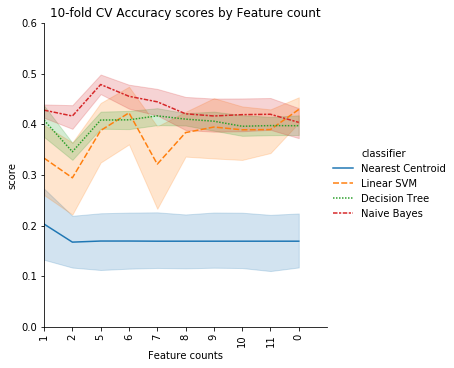

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.relplot(x="x", y="score", kind="line", hue="classifier", style="classifier", data=df_trace)
plt.xticks(range(len(feature_counts)), feature_counts, rotation='vertical')
plt.xlabel("Feature counts")
plt.title("10-fold CV Accuracy scores by Feature count")
axes = plt.gca()
axes.set_ylim([0.0,0.6])
axes.set_xlim([0,len(feature_counts)])
plt.savefig('wq_feature_cnt_eval.pdf')
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
corr = df_train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Wine's Heatmap of correlations between attributes")
plt.savefig('wq_feature_heatmap.pdf')
plt.show()